# Benchmarking Our Algorithm against others

In [2]:
import sys
sys.path.append('../')
from panav.environment.env import MultiTunnelEnv
from panav.hybrid import HybridGraph
from panav.util import flowtime,makespan
from panav.PBS.PBS import PBS
from panav.TrafficAwarePlanning import TAHP
from panav.sequential import sequential_planning
from panav.PIBT import PIBT_plan
from panav.SAMP.solvers import Tube_Planning



from time import time
import pickle as pkl

%load_ext autoreload
%autoreload 2

In [10]:

bloating_r = 0.5
vmax = 1.0

n_agents = list(range(10,50,10))
# n_agents = [6]

TIMEOUT = 60 # 1 minute timeout

# Algorithms
algs = {  "PIBT": lambda hg: PIBT_plan(hg,vmax,bloating_r,TIMEOUT),
        "S2M2": lambda hg: PBS(hg.env,vmax=vmax,bloating_r=bloating_r,low_level_planner="Simple_MILP_Planning",TIMEOUT=TIMEOUT)[0],
        "PBS_Tube": lambda hg: PBS(hg.env,vmax=vmax,bloating_r=bloating_r,low_level_planner="Tube_Planning",TIMEOUT=TIMEOUT)[0],
        "TAHP": lambda hg: TAHP(hg,vmax=vmax,bloating_r=bloating_r,TIMEOUT=TIMEOUT),
        "Seq_Tube": lambda hg: sequential_planning(Tube_Planning,hg.env,vmax,bloating_r,TIMEOUT=TIMEOUT),      
        # "Seq_Temp_Obs": lambda hg: sequential_planning(Simple_MILP_Planning,hg.env,vmax,bloating_r,TIMEOUT=TIMEOUT)
        }

timeouted = {alg:False for alg in algs}

results = []

env_name = "MultiTunnel"


In [11]:
# Load checkpoint if necessary

with open("./data/{}_misc.pkl".format(env_name),'rb') as fp:
    ck = pkl.load(fp)
    cur_N = ck['cur_N']



with open("./data/{}.pkl".format(env_name),'rb') as fp:
    results = pkl.load(fp)

In [13]:
cur_N = 0
# Experiments
for i in range(len(n_agents)):
    
    N = n_agents[i]
    if N<cur_N:
        continue

    limits = [(-20,20),(-80,80)] 
    n_tunnel = 20

    env = MultiTunnelEnv(n_tunnel = n_tunnel, tunnel_width = bloating_r*2.5,limits=limits, N_agent = N)

    HG = HybridGraph(env,bloating_r)

    # Save checkpoint data
    with open("./data/{}_misc.pkl".format(env_name),'wb') as fp:
        pkl.dump({"TIMEOUT":TIMEOUT,"HG":HG,'cur_N':N},fp)
        
    to_remove = []
    for e in HG.edges:
        if HG.edges[e]['type']=='soft':
            # HG.edges[e]['weight'] = 0
            # pass
            u,v = e
            if HG.nodes[u]['type']== HG.nodes[v]['type']=='tunnel' and \
                                    HG.nodes[u]['open_space_id'] == HG.nodes[v]['open_space_id']:
                to_remove.append(e) # Remove the soft edges connecting two tunnel endpoints for this particular environment
    for e in to_remove:
        HG.remove_edge(*e)

    for name,alg in algs.items():

        if timeouted[name]:
            continue
        
        print("Alg:", name, "N agent:",N)

        result = {}
        
        t0 = time()
        plan = alg(HG)
        t = time()-t0
        
        result['plan'] = plan
        result['time'] = t

        result['N_agent'] = N
        result['alg_name'] = name

        result["TIMEOUT"]=TIMEOUT
        result["HG"]=HG

        results.append(result)

        
        if t>TIMEOUT:
            timeouted[name] = True
            print("Time out for algorithm", name, "N agent = ", N)


        
        

    # Save checkpoint data
    with open("./data/{}.pkl".format(env_name),'wb') as fp:
        pkl.dump(results,fp)


Alg: PIBT N agent: 10
Alg: S2M2 N agent: 10
PBS Time Elapsed: 1.7367894649505615
PBS Time Elapsed: 1.9549140930175781
PBS Time Elapsed: 2.2212576866149902
PBS Time Elapsed: 2.415041446685791
PBS Time Elapsed: 2.719081163406372
PBS Time Elapsed: 3.0730090141296387
PBS Time Elapsed: 3.4332611560821533
PBS Time Elapsed: 3.810555934906006
PBS Time Elapsed: 4.178743124008179
PBS Time Elapsed: 4.7581634521484375
Skipping ij (3, 1) prev_ordering [(0, 4), (0, 5), (3, 1), (8, 3)]
Skipping ij (1, 3) prev_ordering [(0, 4), (0, 5), (3, 1), (8, 3)]
PBS Time Elapsed: 5.405606508255005
PBS Time Elapsed: 5.956998348236084
Alg: PBS_Tube N agent: 10
PBS Time Elapsed: 1.791585922241211
PBS Time Elapsed: 1.9871904850006104
PBS Time Elapsed: 2.2192628383636475
PBS Time Elapsed: 2.410003185272217
PBS Time Elapsed: 2.6791677474975586
PBS Time Elapsed: 2.8404037952423096
PBS Time Elapsed: 3.139157295227051
PBS Time Elapsed: 3.3059113025665283
PBS Time Elapsed: 3.53775691986084
PBS Time Elapsed: 3.652876615524

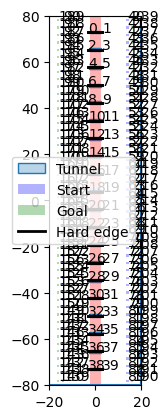

In [9]:
from panav.viz import draw_hybrid

draw_hybrid(HG)